<a href="https://colab.research.google.com/github/mario-rot/ComputerVisionCourse-MAI/blob/main/Session%206/P6_Mario_Lauren.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratory #3_1 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost 
*   Face recognition
    *   Eigen Faces
    *   PCA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.
---

In [143]:
!pip install matplotlib --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.2 MB 18.2 MB/s 
     |████████████████████████████████| 965 kB 54.7 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


In [9]:
%%shell
git clone https://github.com/mario-rot/ComputerVisionCourse-MAI.git
cd 'ComputerVisionCourse-MAI'
mv 'Session 6/images' /content/
mv 'customplots.py' /content/
mv 'utils.py' /content/

fatal: destination path 'ComputerVisionCourse-MAI' already exists and is not an empty directory.
mv: cannot stat 'Session 6/images': No such file or directory
mv: cannot stat 'customplots.py': No such file or directory


# Face Detection using AdaBoost

In [36]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import data, io, transform
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt
from customplots import custom_grids
import pandas as pd

path = '/content/images/'

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from pylab import *
import itertools
from sklearn.metrics import confusion_matrix


def groupedBarPlot(data, xticks, title,legend=True,axislabels = False,width=0.35,figsize=(25,10), barLabel=False, png = False, pdf = False, colors = None, fsizes = False, axisLim = False, xtick_rot=False, bLconfs = ['%.2f', 14]):
    """Width recomendado para 2 barras agrupadas es 0.35, para 3 y 4 es 0.2
       Para usar el barLabel, debe ser una lista de listas por cada tipo,
       aun que sea solo una barra por paso en el eje x deber ser una lista contenida dentro de otra
       Las opciones para fsizes son:
            'font' --> controla el tamaño de los textos por defecto
            'axes' --> tamaño de fuente del titulo y las etiquetas del eje x & y
            'xtick' --> tamaño de fuente de los puntos en el eje x
            'ytick' --> tamaño de fuente en los puntos del eje y
            'legend --> controla el tamaño de fuente de la leyenda
            'figure' --> controla el tamaño de fuente del titulo de la figura
       """
    if fsizes:
        for key,size in fsizes.items():
            if key == 'font':
                plt.rc(key, size=size)
            elif key == 'axes':
                plt.rc(key, titlesize=size)
                plt.rc(key, labelsize=size)
            elif key in ['xtick','ytick']:
                plt.rc(key, labelsize=size)
            elif key == 'legend':
                plt.rc(key, fontsize=size)
            elif key == 'figure':
                plt.rc(key, titlesize=size)
    else:
        plt.rc('font', size=15)

    x = np.arange(len(xticks))
    if colors:
        cl = colors
    else:
        cl = clrs

    if figsize:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = plt.subplots()

    rects = {}
    if len(data) == 1:
        ldata = list(data.values())
        keys = list(data.keys())
        rects[keys[0]] = ax.bar(x, ldata[0], width, label=keys[0], color = cl)
    elif len(data) == 2:
        ldata = list(data.values())
        keys = list(data.keys())
        rects[keys[0]] = ax.bar(x + width/2, ldata[0], width, label=keys[0], color = cl[2])
        rects[keys[1]] = ax.bar(x - width/2, ldata[1], width, label=keys[1], color = cl[3])
    elif len(data) == 3:
        ldata = list(data.values())
        keys = list(data.keys())
        rects[keys[0]] = ax.bar(x, ldata[0], width, label=keys[0])
        rects[keys[1]] = ax.bar([i+width for i in x], ldata[1], width, label=keys[1])
        rects[keys[2]] = ax.bar([i+2*width for i in x], ldata[2], width, label=keys[2])
    elif len(data) == 4:
        ldata = list(data.values())
        keys = list(data.keys())
        rects[keys[0]] = ax.bar(x + width/2, ldata[0], width, label=keys[0], color = cl[0])
        rects[keys[1]] = ax.bar(x - width/2, ldata[1], width, label=keys[1], color = cl[1])
        rects[keys[2]] = ax.bar(x + 1.5*width, ldata[2], width, label=keys[2], color = cl[2])
        rects[keys[3]] = ax.bar(x - 1.5*width, ldata[3], width, label=keys[3], color = cl[3])

    # ax.patch.set_facecolor('red')
    ax.patch.set_alpha(0.0)

    if axislabels:
        ax.set_xlabel(axislabels[0])
        ax.set_ylabel(axislabels[1])

    ax.set_title(title)
    if len(data) == 3:
        ax.set_xticks(x+width)
    else:
        ax.set_xticks(x)
    if xtick_rot:
        ax.set_xticklabels(xticks, rotation = xtick_rot)
    else:
        ax.set_xticklabels(xticks)

    if legend:
        ax.legend(prop={"size":30})

    if barLabel:
#         error = ['Hola' for i in range(9)]
#         ax.bar_label(list(rects.values())[0], padding=3, labels=[ e for e in error])
        try:
            for j,i in enumerate(rects.values()):
                ax.bar_label(i, padding=3, labels=[barLabel[0][:].format(ldata[j][r], barLabel[j+1][r]) for r in range(len(ldata[0]))])
        except:
            for j,i in enumerate(rects.values()):
                ax.bar_label(i, padding=3, labels=['{}\n{:.2f}%'.format(ldata[j][r], barLabel[j][r]) for r in range(len(ldata[0]))])
    else:
        for i in rects.values():
            ax.bar_label(i, padding=3, fmt = bLconfs[0], fontsize = bLconfs[1])

    fig.tight_layout()

    if axisLim:
        for key,values in axisLim.items():
            if key == 'xlim':
                plt.xlim(values[0], values[1])
            elif key == 'ylim':
                plt.ylim(values[0], values[1])

    if png:
        plt.savefig(png + '.png', transparent=True)
    if pdf:
        plt.savefig(pdf + '.pdf', transparent=True)

    plt.show()


In [ ]:
def plot_external_index(df: pd.DataFrame,
                        title: Optional[str] = None):
    external_indexs = ['ARI', 'AMI', 'homo', 'compl', 'v-measure']
    ylabels = ['Adjusted Rand-Index',
               'Adjusted Mutual',
               'Homogeneity',
               'Completeness',
               'V-measure']

    fixed_cols = ['n_clusters']
    selected_columns = fixed_cols + external_indexs
    new_df = df[selected_columns]
    new_df.columns = fixed_cols + ylabels

    fig, ax0 = plt.subplots(1, 1, figsize=(10, 5))
    fig.suptitle(title)
    new_df.plot.bar(x='n_clusters', rot=0, alpha=0.8, ax=ax0)
    ax0.set_xlabel('n cluster')
    ax0.legend(loc='best')
    ax0.set_ylabel('External index')
    fig.tight_layout()

    return fig

### Exercise #1

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [4]:
def compute_integral_image(img_arr):
    """
    Calculates the integral image based on the original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    
    # Add code here
    ii = np.array(transform.integral_image(img_arr))
    for r in range(len(ii)):
      for c in range(len(ii[0])):
        integral_image_arr[r+1][c+1] = ii[r][c]


    return integral_image_arr

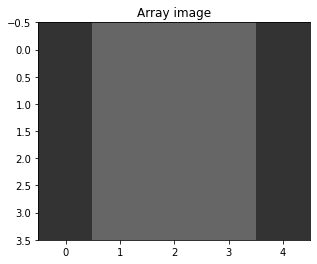

In [5]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
plt.imshow(img_array, cmap="gray", vmin=0, vmax= 5)
plt.title("Array image")
plt.show()

In [6]:
ii_img_array = compute_integral_image(img_array)
print(ii_img_array)

[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

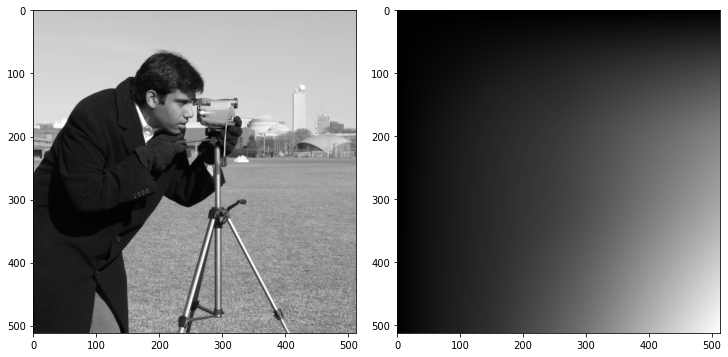

In [13]:
# solution
camera = data.camera()

camera_ii = compute_integral_image(camera)

custom_grids([camera, camera_ii], 1, 2, cmap='gray').show()




### Exercise #2

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [22]:
def sum_region(integral_img_arr, top_left, bottom_right):

    
    # Add code here
    sum = integral_img_arr[bottom_right[0]][bottom_right[1]]
    sum -= integral_img_arr[top_left[0]][bottom_right[1]]
    sum -= integral_img_arr[bottom_right[0]][top_left[1]]
    sum += integral_img_arr[top_left[0]][top_left[1]]
    
    
    return sum

*   Make the following tests:

In [23]:
# result you should get (12)
print(sum_region(ii_img_array, [1, 1], [3, 4]))

12.0


In [24]:
# result you should get (32)
print(sum_region(ii_img_array, [0, 0], [-1, -1]))

32.0


### Exercise #3

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [51]:
if 'face01428.png' in os.listdir(dir_path):
  plt.imread('images/train_data/faces/face01428.png')

In [75]:
def load_integral_images(path):
    ii_images = []
    original_images = []
    for _file in os.listdir(path):
        #### Complete here:
        #### Read image
        #### Remember to scale the images (with the max pixel intensity value)
        if _file[-4:] == '.png': 
        
          curr_file = plt.imread(path +'/'+ _file)
          original_images.append(curr_file)
          ii_img = compute_integral_image(curr_file)
          max_pixel = ii_img.max()
          ii_img = ii_img / max_pixel
          ii_images.append(ii_img) 

    return original_images, ii_images


# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

*   Use the load_integral_images function to compute the integral images of training and testing data

In [63]:
# change paths to your location

root_dir = path

pos_training_path = os.path.join(root_dir, 'train_data/faces')
neg_training_path = os.path.join(root_dir, 'train_data/non_faces')
pos_testing_path = os.path.join(root_dir, 'test_data/faces')
neg_testing_path = os.path.join(root_dir, 'test_data/non_faces')


In [76]:
# solution
pos_training_orig, pos_training_ii = load_integral_images(pos_training_path)
neg_training_orig, neg_training_ii = load_integral_images(neg_training_path)
pos_testing_orig, pos_testing_ii = load_integral_images(pos_testing_path)
neg_testing_orig, neg_testing_ii = load_integral_images(neg_testing_path)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


In [66]:
pos_training_orig

[]

*   Visualize a few original images and the corresponding integral images using matplotlib.

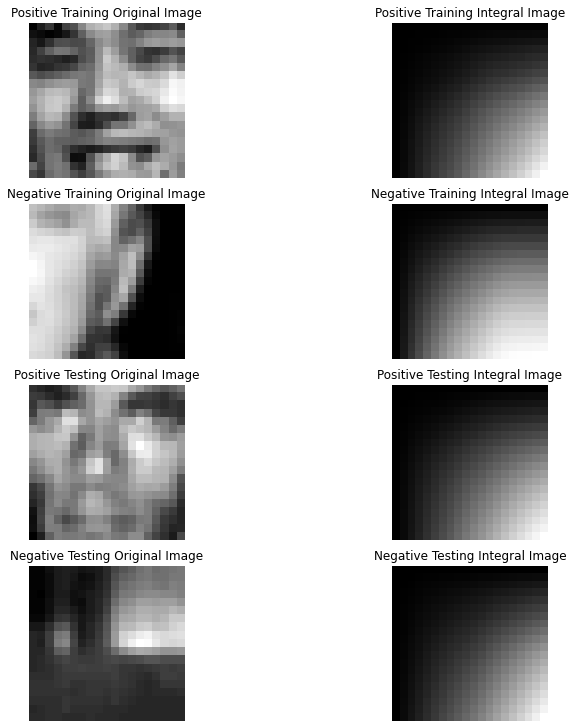

In [81]:
# solution


imgs = [pos_training_orig[0], pos_training_ii[0], neg_training_orig[0], neg_training_ii[0],
        pos_testing_orig[0], pos_testing_ii[0], neg_testing_orig[0], neg_testing_ii[0]]

titles = ['Positive Training Original Image', 'Positive Training Integral Image', 
          'Negative Training Original Image', 'Negative Training Integral Image',
          'Positive Testing Original Image', 'Positive Testing Integral Image',
          'Negative Testing Original Image', 'Negative Testing Integral Image']

custom_grids(imgs, 4, 2, cmap='gray', axis='off', titles=titles).show()


### Exercise #4

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [82]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [87]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1
    
    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score
    
    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray
        
        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [88]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int
    
    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1)) 

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))

    
    print('\tTime needed for calculating scores:', time.time()-t0)
    
    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values 
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                for x in range(img_width - feature_width):
                    for y in range(img_height - feature_height):
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, 1))
                        features.append(HaarLikeFeature(feature, (x, y), feature_width, feature_height, 0, -1))
                          
    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Haar-like features:', time.time()-t0)
    return features

### Exercise #5

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [89]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [90]:
# solution

%%time 

classifiers = learn(pos_training_ii, neg_training_ii, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.004450559616088867
Calculating scores for images..
	Time needed for calculating scores: 256.22676491737366
Selecting classifiers..
	Time needed for Selecting Classifiers: 29.386162042617798 

CPU times: user 1min 55s, sys: 7.67 s, total: 2min 2s
Wall time: 4min 45s


In [92]:
classifiers[0]

### Exercise #6

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [94]:
# solution
def ensemble_vote(int_img, classifiers):
  if np.array([c.get_vote(int_img) for c in classifiers]).sum() >= 0:
    return 1
  else:
    return 0

def ensemble_vote_all(int_imgs, classifiers):
  vote_list = []
  for img in int_imgs:
    vote_list.append(ensemble_vote(img, classifiers))
  return vote_list


*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [110]:
# solution
print('train results:')
positive_training = ensemble_vote_all(pos_training_ii, classifiers)
print('Correctly identified Faces: {}/{}  ({}%)'.format(positive_training.count(1), len(positive_training), (positive_training.count(1)/len(positive_training)*100)))
negative_training = ensemble_vote_all(neg_training_ii, classifiers)
print('Correctly identified non-faces: {}/{}  ({}%)'.format(negative_training.count(1), len(negative_training), (negative_training.count(1)/len(negative_training)*100)))
print('')
print('test results:')
positive_testing = ensemble_vote_all(pos_testing_ii, classifiers)
print('Correctly identified Faces: {}/{}  ({}%)'.format(positive_testing.count(1), len(positive_testing), (positive_testing.count(1)/len(positive_testing)*100)))
negative_testing = ensemble_vote_all(neg_testing_ii, classifiers)
print('Correctly identified non-faces: {}/{}  ({}%)'.format(negative_testing.count(1), len(negative_testing), (negative_testing.count(1)/len(negative_testing)*100)))


train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-faces: 4280/8555  (50.02922267679719%)

test results:
Correctly identified Faces: 299/472  (63.347457627118644%)
Correctly identified non-faces: 53/128  (41.40625%)


### Exercise #7

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [105]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [106]:
# solution

%%time 

classifiers_20 = learn(pos_training_ii, neg_training_ii, num_classifiers, min_feature_width, max_feature_width, min_feature_height, max_feature_height)

Creating Haar-like features..
	2496 features created.
	Time needed for calculating Haar-like features: 0.003056049346923828
Calculating scores for images..
	Time needed for calculating scores: 272.04607343673706
Selecting classifiers..
	Time needed for Selecting Classifiers: 320.48704648017883 

CPU times: user 6min 39s, sys: 8.39 s, total: 6min 47s
Wall time: 9min 52s


*   Discuss if the classification results improved in the train data.


In [108]:
# solution
print('train results:')
positive_training = ensemble_vote_all(pos_training_ii, classifiers_20)
print('Correctly identified Faces: {}/{}  ({}%)'.format(positive_training.count(1), len(positive_training), (positive_training.count(1)/len(positive_training)*100)))
negative_training = ensemble_vote_all(neg_training_ii, classifiers_20)
print('Correctly identified non-faces: {}/{}  ({}%)'.format(negative_training.count(1), len(negative_training), (negative_training.count(1)/len(negative_training)*100)))
print('')
print('test results:')
positive_testing = ensemble_vote_all(pos_testing_ii, classifiers_20)
print('Correctly identified Faces: {}/{}  ({}%)'.format(positive_testing.count(1), len(positive_testing), (positive_testing.count(1)/len(positive_testing)*100)))
negative_testing = ensemble_vote_all(neg_testing_ii, classifiers_20)
print('Correctly identified non-faces: {}/{}  ({}%)'.format(negative_testing.count(1), len(negative_testing), (negative_testing.count(1)/len(negative_testing)*100)))


train results:
Correctly identified Faces: 2224/2429  (91.56031288596131%)
Correctly identified non-faces: 1440/8555  (16.832261835184102%)

test results:
Correctly identified Faces: 246/472  (52.118644067796616%)
Correctly identified non-faces: 25/128  (19.53125%)


**Solution**

*(Double-click or enter to edit)*

...

### Exercise #8

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [120]:
# solution
def ensemble_vote_t(int_img, classifiers, threshold):
  if np.array([c.get_vote(int_img) for c in classifiers]).sum() >= threshold:    
    return 1
  else:
    return 0

def ensemble_vote_all_t(int_imgs, classifiers, threshold):
  vote_list = []
  for img in int_imgs:
    vote_list.append(ensemble_vote_t(img, classifiers, threshold))
  return vote_list


*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [119]:
thresholds

array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4])

In [127]:
# solution
thresholds = np.array([x for x in range(-5,5,1)])/10.
ptr,ntr,pts,nts = [],[],[],[]
for threshold in thresholds:
  print('######################## Threshold = {} ########################'.format(threshold))
  print('train results:')
  positive_training = ensemble_vote_all_t(pos_training_ii, classifiers_20, threshold)
  ptr.append((positive_training.count(1)/len(positive_training)*100))
  print('Correctly identified Faces: {}/{}  ({}%)'.format(positive_training.count(1), len(positive_training), (positive_training.count(1)/len(positive_training)*100)))
  negative_training = ensemble_vote_all_t(neg_training_ii, classifiers_20, threshold)
  ntr.append((negative_training.count(1)/len(negative_training)*100))
  print('Correctly identified non-faces: {}/{}  ({}%)'.format(negative_training.count(1), len(negative_training), (negative_training.count(1)/len(negative_training)*100)))
  print('')
  print('test results:')
  positive_testing = ensemble_vote_all_t(pos_testing_ii, classifiers_20, threshold)
  pts.append((positive_testing.count(1)/len(positive_testing)*100))
  print('Correctly identified Faces: {}/{}  ({}%)'.format(positive_testing.count(1), len(positive_testing), (positive_testing.count(1)/len(positive_testing)*100)))
  negative_testing = ensemble_vote_all_t(neg_testing_ii, classifiers_20, threshold)
  nts.append((negative_testing.count(1)/len(negative_testing)*100))
  print('Correctly identified non-faces: {}/{}  ({}%)'.format(negative_testing.count(1), len(negative_testing), (negative_testing.count(1)/len(negative_testing)*100)))
  print('')


######################## Threshold = -0.5 ########################
train results:
Correctly identified Faces: 2370/2429  (97.57101687937423%)
Correctly identified non-faces: 2673/8555  (31.244886031560494%)

test results:
Correctly identified Faces: 346/472  (73.30508474576271%)
Correctly identified non-faces: 44/128  (34.375%)

######################## Threshold = -0.4 ########################
train results:
Correctly identified Faces: 2344/2429  (96.50061753808151%)
Correctly identified non-faces: 2348/8555  (27.44593804792519%)

test results:
Correctly identified Faces: 325/472  (68.85593220338984%)
Correctly identified non-faces: 39/128  (30.46875%)

######################## Threshold = -0.3 ########################
train results:
Correctly identified Faces: 2319/2429  (95.47138740222314%)
Correctly identified non-faces: 2118/8555  (24.757451782583285%)

test results:
Correctly identified Faces: 311/472  (65.88983050847457%)
Correctly identified non-faces: 34/128  (26.5625%)

#####

*   Make a bar plot for 1-4. In the x axis write the threshold value.

In [ ]:
# solution
plt.bar(list(range(0, )), self.explained_variance_ratio, color=colors[2])


*   Discuss what happens when you increase the threshold value.

In [138]:
data = {'positive_training':ptr,
        'negative_training':ntr,
        'positive_testing':pts,
        'negative_testing':nts}
xtic=thresholds
title = 'Classification succes by tresholds'

In [139]:
len(xtic)

10

AttributeError: ignored

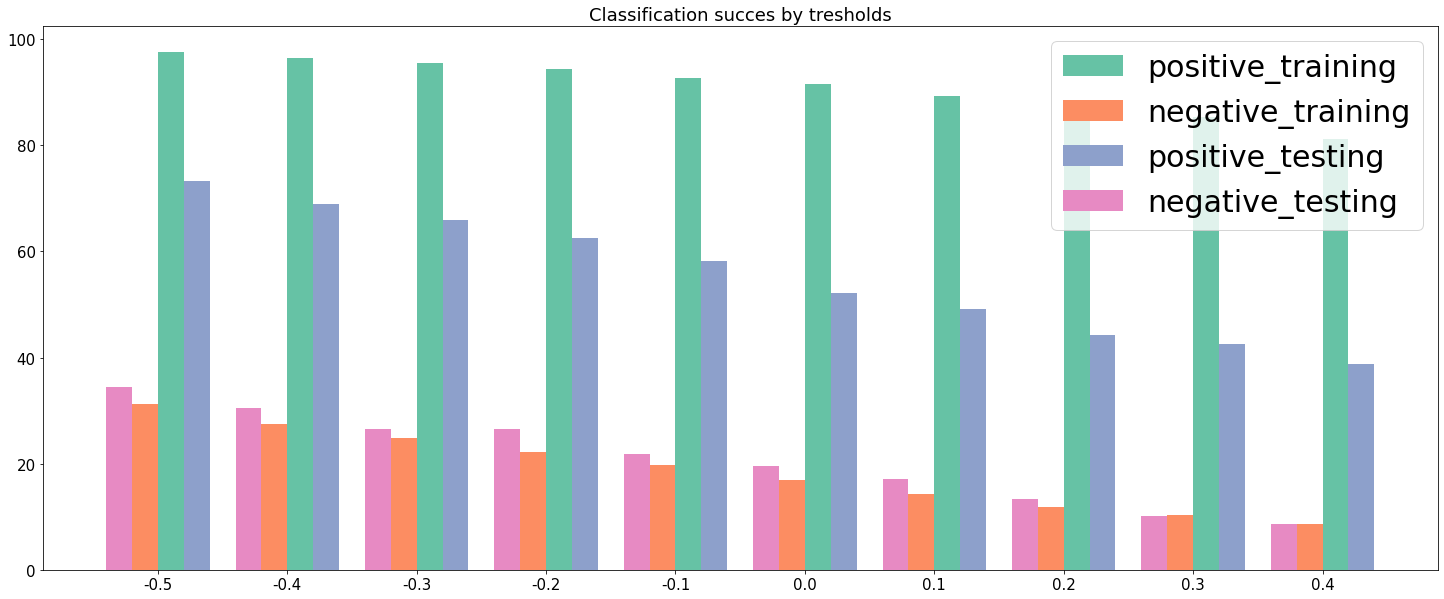

In [142]:
groupedBarPlot(data, xtic, title, colors=plt.cm.Set2.colors, width = 0.2)

**Solution**

*(Double-click or enter to edit)*

...

# Face Recognition using PCA


In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

*   Loading the dataset

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

*   Creating training and testing set

In [ ]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print('Train data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Number of classes in Train set:', np.unique(y_train).shape[0])

### Exercise #1: PCA Computation
*   Compute a PCA (eigenfaces) on the face dataset
    *   *Set* number of components to 100

In [ ]:
# solution



*   Reshape the components output of pca to obtain the eigen faces

In [ ]:
# solution



*   Project the training and testing faces data on the orthonormal basis

In [ ]:
# solution



*   Plot the most significative eigenfaces (Show the top 12 eigenfaces) as a matplotlib

In [ ]:
# solution



*   Show the total percentage of variance explained by the selected components of the PCA.


In [ ]:
# solution



*   What are the shortcomings of PCA?

**Solution**

*(Double-click or enter to edit)*

...

### Exercise #2: k-NN Classification

*   Train a k-nearest neighbor model with the eigenfaces using the default parameters

In [ ]:
# solution



*   Predict the test data using the trained classifier

In [ ]:
# Quantitative evaluation of the model quality on the test set



### Exercise #3: Quantitative results

*   Compute accuracy, classification report and confusion matrix of the trained classifier

In [ ]:
# solution



In [ ]:
# solution



In [ ]:
# solution



*   Explain the measures showed in the classification report.
*   Discuss the obtained classification results, both the quantitative as well as the qualitative results.

**Solution**

*(Double-click or enter to edit)*

...

### Exercise #4

*   How is the optimal value of 'k' found?

**Solution**

*(Double-click or enter to edit)*

...

*   Use GridSearch to find the optimal value of 'k'.
    *   *Hint: GridSearchCV is available in sklearn.model_selection*
*   What is the accuracy of the best estimator?

In [ ]:
# solution



### Exercise #5: Qualitative evaluation

*   Plot some of the prediction images using matplotlib subplots (4 x 4). Show the true label and predicted label as the title of each sub plot.

In [ ]:
# solution



*   What are the disadvantages of using kNN

**Solution**

*(Double-click or enter to edit)*

...


---

# **End of L3_1: Face Detection and Recognition**
Deadline for L3_1 submission in CampusVirtual is: **Thursday, the 10th of November, 2022**